In [101]:
flatfile_fname <- 'data/new_SD_PGA.csv'
source('R_lib/regression/inla/regression_inla_model1_unbounded_hyp.R')

#load flatfile
utmzone = 10
df_flatfile <- read.csv(flatfile_fname)
names(df_flatfile) <- c('eqid','date','eqlat','eqlon','eqZ','mag','SD','SDD','Site','R','Vs30','Vs30class','PGA','stalat','stalon')
df_flatfile$ssn <- df_flatfile$Site
df_flatfile$UTMzone <- utmzone #north california

df_flatfile<- subset(df_flatfile,mag<6)

eq<-LongLatToUTM(df_flatfile$eqlat,df_flatfile$eqlon,utmzone)
df_flatfile[,c('eqX','eqY')] <- eq[,c('X','Y')]/1000

sta<-LongLatToUTM(df_flatfile$stalat,df_flatfile$stalon,utmzone)
df_flatfile[,c('staX','staY')] <- sta[,c('X','Y')]/1000


# Preprocess Input Data
# ---------------------------
n_data <- nrow(df_flatfile)
#earthquake data
data_eq_all <- df_flatfile[,c('eqid','mag','eqX', 'eqY')]
out_unq  <- UniqueIdxInv(df_flatfile[,'eqid'])
eq_idx   <- out_unq$idx
eq_inv   <- out_unq$inv
data_eq  <- data_eq_all[eq_idx,]
X_eq     <- data_eq[,c(3,4)] #earthquake coordinates
X_eq_all <- data_eq_all[,c(3,4)]
#create earthquake ids for all records (1 to n_eq)
eq_id <- eq_inv
n_eq  <- nrow(data_eq)



#station data
data_sta_all <- df_flatfile[,c('ssn','Vs30','staX','staY')]
out_unq   <- UniqueIdxInv(df_flatfile[,'ssn'])
sta_idx   <- out_unq$idx
sta_inv   <- out_unq$inv
data_sta  <- data_sta_all[sta_idx,]
X_sta     <- data_sta[,c(3,4)] #station coordinates
X_sta_all <- data_sta_all[,c(3,4)]
#create station indices for all records (1 to n_sta)
sta_id <- sta_inv
n_sta  <- nrow(data_sta)

##
df_flatfile[,c('eq_id','sta_id')] = c(eq_id,sta_id)

In [99]:
#plot
library(ggplot2)
library(patchwork)
library(INLA)
library(dplyr)

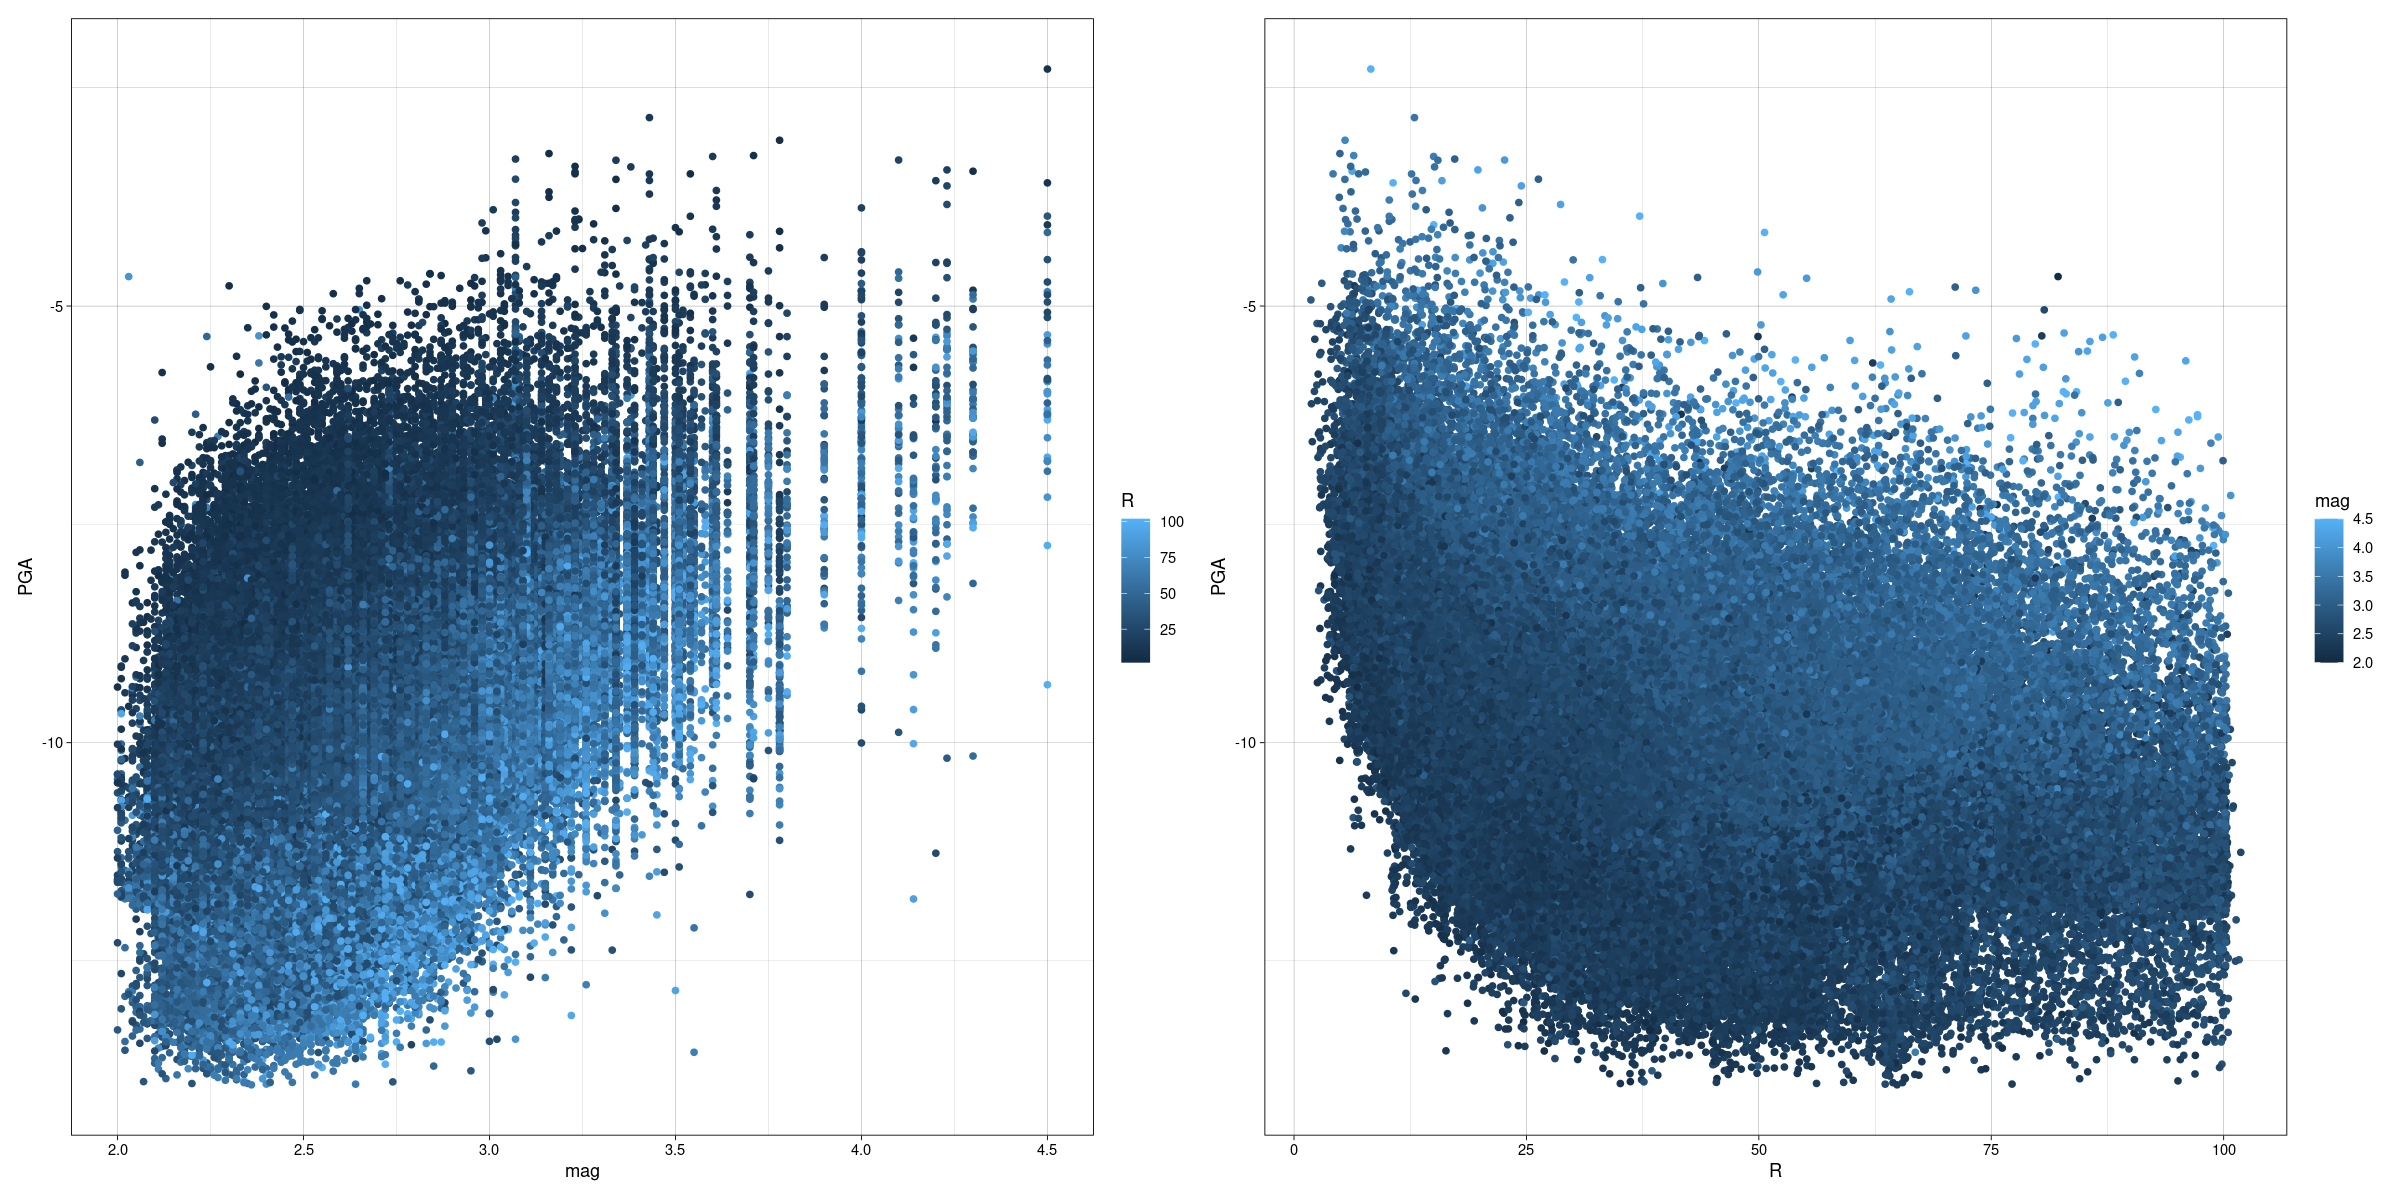

In [102]:
options(repr.plot.width=20, repr.plot.height=10)

p1 <- ggplot(df_flatfile) + 
  geom_point(aes(x = mag, y = PGA, color=R))

p2 <- ggplot(df_flatfile) + 
  geom_point(aes(x = R, y = PGA, color=mag))

p1 + p2

In [80]:
Y <- df_flatfile[,'PGA']
M <- df_flatfile[,'mag']
R <- Y <- df_flatfile[,'R']

In [83]:
lmod <- lm(Y ~ 1 + M + log(R))
summary(lmod)


Call:
lm(formula = Y ~ 1 + M + log(R))

Residuals:
   Min     1Q Median     3Q    Max 
-6.406 -4.887 -2.796  2.501 60.398 

Coefficients:
             Estimate Std. Error  t value Pr(>|t|)    
(Intercept) -80.06424    0.14941 -535.877   <2e-16 ***
M             0.50072    0.05269    9.503   <2e-16 ***
log(R)       33.52333    0.02843 1179.229   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 6.777 on 180950 degrees of freedom
Multiple R-squared:  0.8918,	Adjusted R-squared:  0.8918 
F-statistic: 7.459e+05 on 2 and 180950 DF,  p-value: < 2.2e-16


In [122]:
data_regression <- data.frame(M, R, eq_id, sta_id)

fit_inla <- inla(Y ~ 1+M+f(eq_id,model="iid"), data=data_regression,num.threads=8)
summary(fit_inla)


Call:
   c("inla(formula = Y ~ 1 + M + f(eq_id, model = \"iid\"), data = 
   data_regression, ", " num.threads = 8)") 
Time used:
    Pre = 0.312, Running = 93.6, Post = 0.098, Total = 94 
Fixed effects:
              mean    sd 0.025quant 0.5quant 0.975quant   mode kld
(Intercept) -6.471 1.213     -8.854   -6.471     -4.091 -6.471   0
M           17.165 0.479     16.225   17.165     18.104 17.165   0

Random effects:
  Name	  Model
    eq_id IID model

Model hyperparameters:
                                         mean   sd 0.025quant 0.5quant
Precision for the Gaussian observations 0.003 0.00      0.003    0.003
Precision for eq_id                     0.013 0.00      0.012    0.013
                                        0.975quant  mode
Precision for the Gaussian observations      0.003 0.003
Precision for eq_id                          0.013 0.012

Expected number of effective parameters(stdev): 4461.11(15.53)
Number of equivalent replicates : 40.56 

Marginal log-Likelihood:  -7

In [123]:
delta_B<-fit_inla$summary.random$eq_id

In [124]:
event<-df_flatfile %>% group_by(eq_id) %>% filter(row_number()==1)
dataM=event[,'mag']

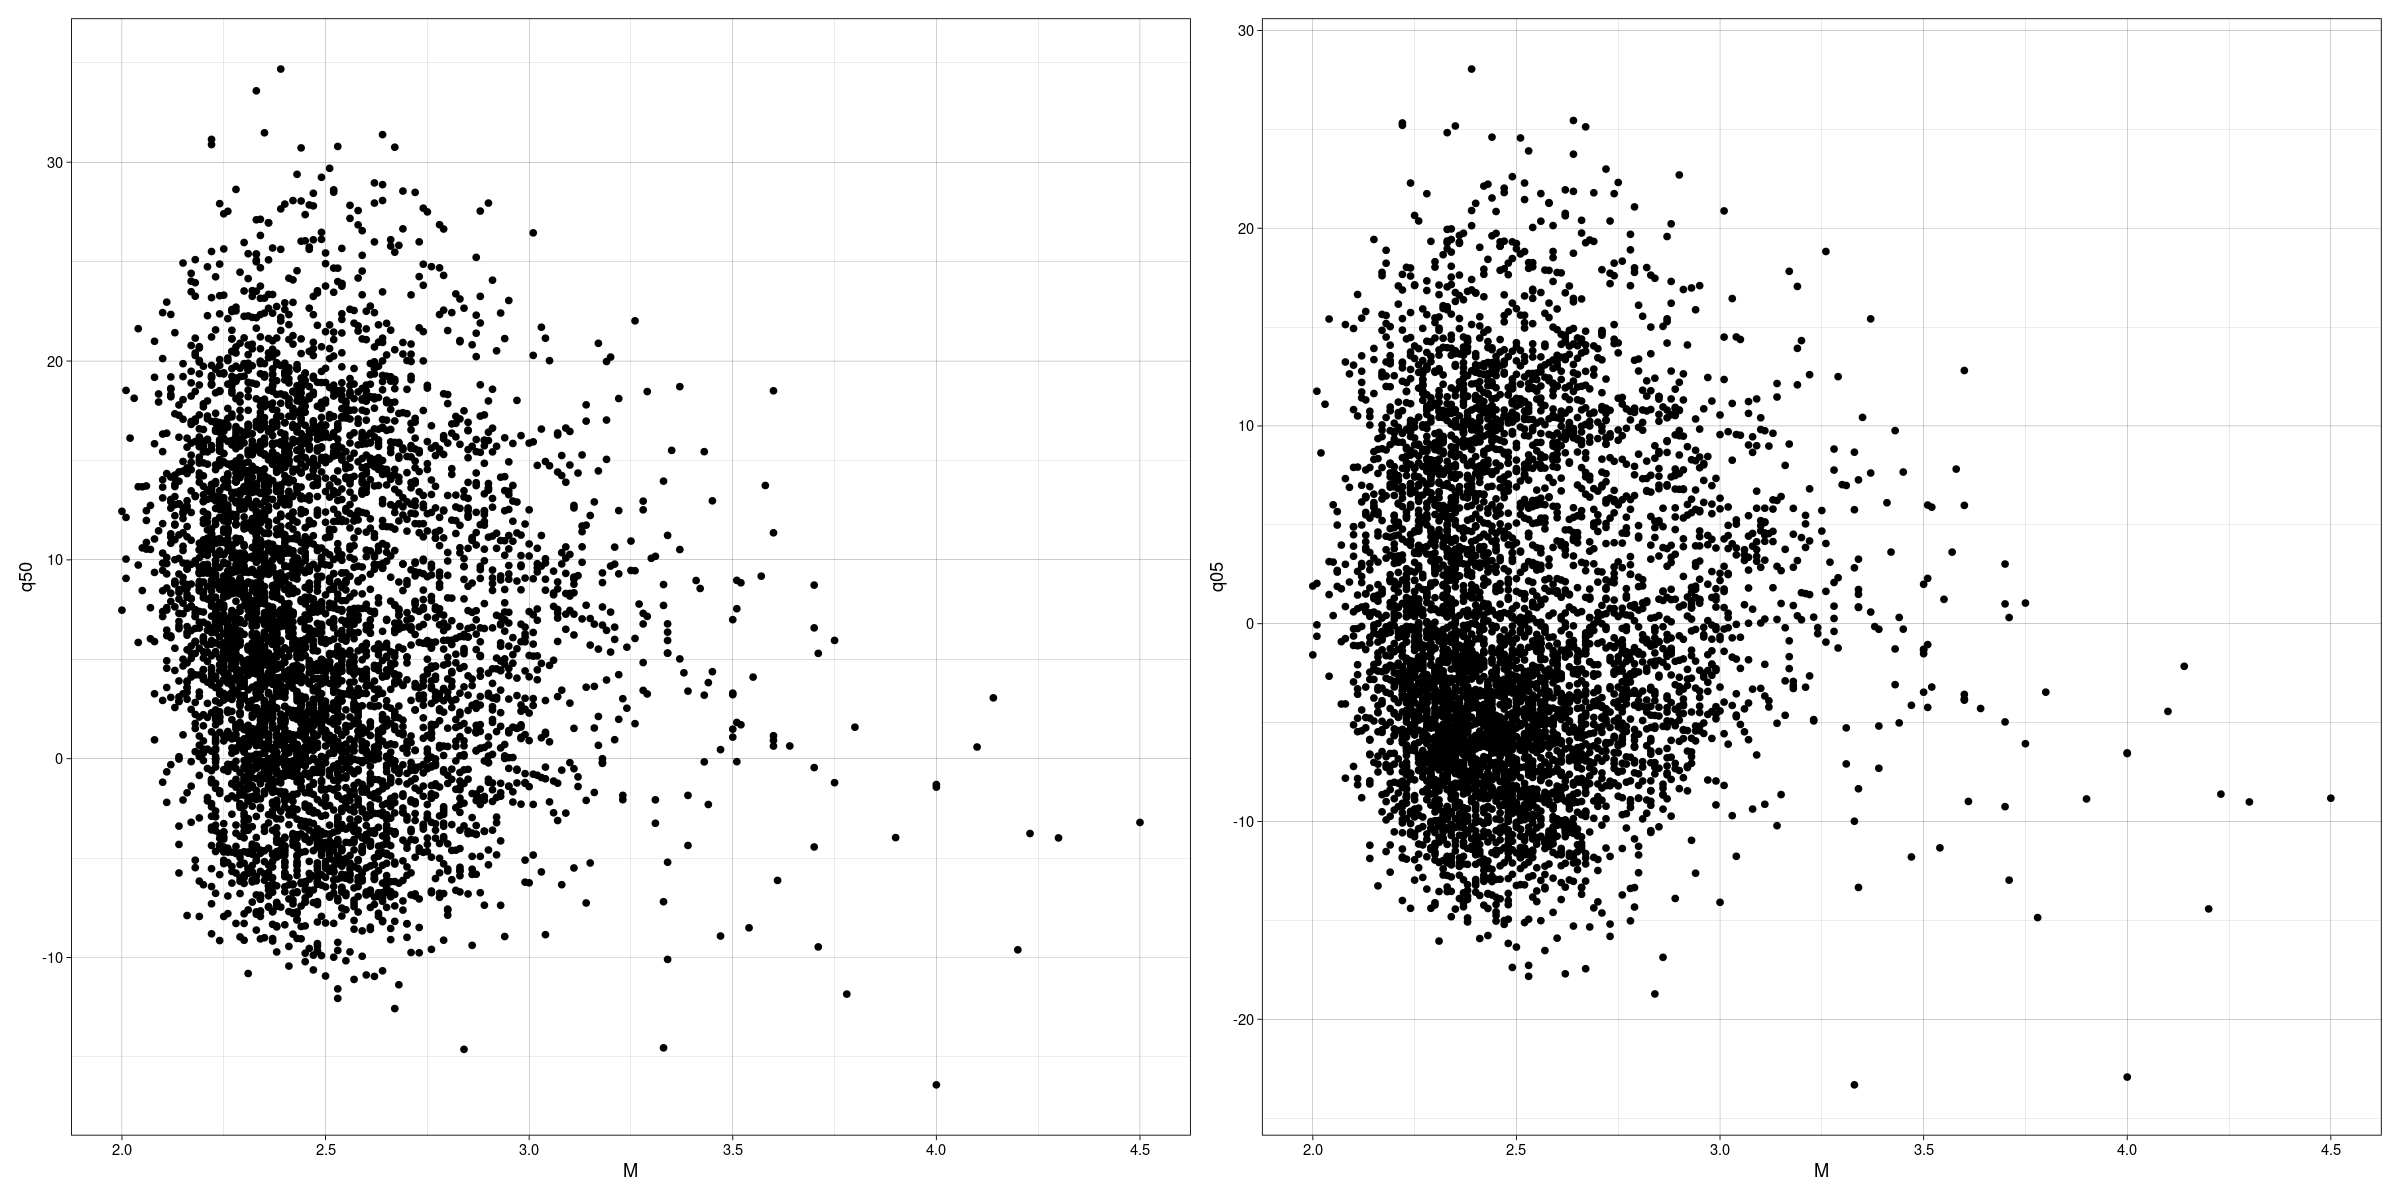

In [125]:
df_plot <-cbind(dataM,delta_B)
names(df_plot)[c(1,2)] <- c('M','DeltaB')
names(df_plot)[c(6,7,8)] <- c('q05','q50','q95')

q1<-ggplot(df_plot,aes(x=M,y=q50))+geom_point()
q2<-ggplot(df_plot,aes(x=M,y=q05))+geom_point()

q1+q2